# **Session Data Cleaning & Outlier Handling: Transforming Noise into Insights**


## **Introduction: From Raw Data to Analytical Readiness**

In the previous notebook (`load_data.py`), we **loaded and enriched** Elena’s cohort, isolating **49,211 sessions** from highly engaged users. However, the raw dataset revealed **critical challenges**:
- **Missing booking details** in over **70% of sessions**.
- **Extreme outliers**, like **$21,548 flight fares** and **566 page clicks**, distorting analysis.
- **Data inconsistencies**, such as **negative nights stayed** and **canceled trips**, requiring correction.

This notebook, **`session_cleaner.ipynb`**, focuses on **cleaning, standardizing, and preparing** the dataset for reliable analysis. Using the **`SessionCleaner` class**, we will:
1. **Remove canceled trips** and incomplete records.
2. **Detect and handle outliers** using statistical methods (IQR, Z-score).
3. **Correct illogical values** (e.g., negative stays, unrealistic prices).
4. **Visualize transformations** to ensure data integrity.

By the end, we’ll have a **clean, model-ready dataset**—free of noise and primed for **exploratory analysis, feature engineering, and predictive modeling**.

---
**Goal**: Convert raw, messy data into a **trusted foundation** for TravelTide’s behavioral and pricing insights. 🚀

### **Environment Setup & Path Configuration**

* **Action:** The notebook begins by cleaning the system path (`sys.path`) to ensure no conflicting modules are loaded. It explicitly removes bad paths and adds the project root directory.
* **Purpose:** This ensures the custom `src` library can be imported correctly, which contains the essential `DataLoader`tools.

In [1]:
import sys, os  # noqa: E401
from IPython.display import display

bad_paths = [
    "/Users/guykaptue/my_work_spaces/machine learning",
    "/Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/src"
]
sys.path = [p for p in sys.path if os.path.abspath(p) not in bad_paths]

print("Clean sys.path:")
for p in sys.path:
    print(" -", p)

Clean sys.path:
 - /opt/anaconda3/envs/ml311/lib/python311.zip
 - /opt/anaconda3/envs/ml311/lib/python3.11
 - /opt/anaconda3/envs/ml311/lib/python3.11/lib-dynload
 - 
 - /opt/anaconda3/envs/ml311/lib/python3.11/site-packages
 - __editable__.tts_mastery_project-0.1.0.finder.__path_hook__


In [2]:

import pandas as pd  # noqa: F401

# ------------------------------------------------------------
# 1️⃣ Determine project root dynamically
# - Works even if notebook is in a subfolder of notebooks/
# ------------------------------------------------------------
cwd = os.getcwd()
print("Current working directory:", cwd)

# Project root = traveltide_project folder
# Assumes notebooks/ is directly under traveltide_project/
project_root = os.path.abspath(os.path.join(cwd, "..", ".."))
print("Project root:", project_root)

## ------------------------------------------------------------
# 2️⃣ Add project root to sys.path for imports
# ------------------------------------------------------------
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("Project root added to sys.path:", project_root)

Current working directory: /Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/notebooks/preparing_data
Project root: /Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project
Project root added to sys.path: /Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project


In [3]:
try:
    import src
    print("✅ src module found at:", src.__file__)
except ModuleNotFoundError as e:
    print("❌ src module not found:", e)


✅ src module found at: /Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/src/__init__.py


In [4]:
from src.core import (
    DataLoader, # noqa: F401
    SessionCleaner, # noqa: F401
    TravelTideEDA, # noqa: F401
) 

In [5]:
# Pfad für EDA-Abbildungen
cleaner_data_path = os.path.join(project_root, 'data', 'csv', 'processed')
os.makedirs(cleaner_data_path, exist_ok=True)

In [6]:
loader = DataLoader()
session_cleaner = SessionCleaner(verbosity=3)

✅ Verbindung zur PostgreSQL-Datenbank hergestellt.
SessionCleaner initialized with verbosity=3
Output directory resolved to: /Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/reports/cleaner


In [7]:
sessions = loader.load_table(data_type='raw', table_name='elena_cohort')

📁 Lade Tabelle 'elena_cohort' aus CSV: /Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/data/csv/raw/elena_cohort.csv
✅ CSV geladen. Zeilen: 49211


In [8]:
# List of datetime columns in base_sessions
date_columns = [
    'birthdate',          # User's date of birth
    'sign_up_date',       # User's registration date
    'session_start',      # Start timestamp of the session
    'session_end',        # End timestamp of the session
    'departure_time',     # Flight departure time
    'return_time',        # Flight return time
    'check_in_time',      # Hotel check-in time
    'check_out_time'      # Hotel check-out time
]

# Convert datetime columns to pandas datetime format
for col in date_columns:
    if col in sessions.columns:
        sessions[col] = pd.to_datetime(sessions[col], errors='coerce')

# Optional: Verify successful conversion
print("✅ Datetime columns after conversion:")
print(sessions[date_columns].dtypes)


✅ Datetime columns after conversion:
birthdate         datetime64[ns]
sign_up_date      datetime64[ns]
session_start     datetime64[ns]
session_end       datetime64[ns]
departure_time    datetime64[ns]
return_time       datetime64[ns]
check_in_time     datetime64[ns]
check_out_time    datetime64[ns]
dtype: object


In [9]:
# session duration calculation
sessions['session_duration'] = (sessions['session_end'] - sessions['session_start']).dt.total_seconds()

In [10]:
stats=session_cleaner.describe_columns(sessions)


Generating descriptive statistics for columns: ['page_clicks', 'flight_discount_amount', 'hotel_discount_amount', 'seats', 'checked_bags', 'base_fare_usd', 'nights', 'rooms', 'hotel_price_per_room_night_usd', 'session_duration']
Summary statistics:


,count,mean,std,min,25%,50%,75%,max
page_clicks,49211.0,17.588791,21.495987,1.00,6.0000,13.000,22.0000,566.00
flight_discount_amount,8282.0,0.139864,0.083914,0.05,0.1000,0.100,0.2000,0.60
hotel_discount_amount,6205.0,0.112192,0.062119,0.05,0.0500,0.100,0.1500,0.45
seats,14270.0,1.215207,0.585891,1.00,1.0000,1.000,1.0000,8.00
checked_bags,14270.0,0.592922,0.677641,0.00,0.0000,1.000,1.0000,8.00
base_fare_usd,14270.0,525.901390,818.296468,2.41,200.4325,381.765,600.6325,21548.04
nights,14726.0,3.672484,3.806717,-2.00,1.0000,2.000,5.0000,43.00
rooms,14726.0,1.194554,0.499344,1.00,1.0000,1.000,1.0000,4.00
hotel_price_per_room_night_usd,14726.0,177.937390,118.334569,17.00,99.0000,148.000,222.0000,1376.00
session_duration,26829.0,86.961795,124.735078,6.00,35.0000,60.000,105.0000,7200.00


In [11]:
outlier_info, outlier_columns = session_cleaner.detect_outlier_columns(sessions)

⏭️  Skipping 'seats' - IQR=0 (all values identical)
⏭️  Skipping 'rooms' - IQR=0 (all values identical)

🎯 Detected 6 columns with EXTREME outliers
Criteria: IQR extreme_threshold=3.0, min 1.0% outliers
📊 Skipped 2 low-variance columns: ['seats', 'rooms']


In [12]:
print("\n✅ Outlier Columns Detected Information:")
display(outlier_info)


✅ Outlier Columns Detected Information:


{'page_clicks': {'extreme_outlier_count': 1025,
  'extreme_percentage': np.float64(2.08),
  'normal_outlier_count': 2103,
  'normal_percentage': np.float64(4.27),
  'max_deviation': np.float64(34.0),
  'total_values': 49211,
  'cv': np.float64(1.222)},
 'checked_bags': {'extreme_outlier_count': 29,
  'extreme_percentage': np.float64(0.2),
  'normal_outlier_count': 169,
  'normal_percentage': np.float64(1.18),
  'max_deviation': np.float64(7.0),
  'total_values': 14270,
  'cv': np.float64(1.143)},
 'base_fare_usd': {'extreme_outlier_count': 453,
  'extreme_percentage': np.float64(3.17),
  'normal_outlier_count': 867,
  'normal_percentage': np.float64(6.08),
  'max_deviation': np.float64(52.34),
  'total_values': 14270,
  'cv': np.float64(1.556)},
 'nights': {'extreme_outlier_count': 151,
  'extreme_percentage': np.float64(1.03),
  'normal_outlier_count': 701,
  'normal_percentage': np.float64(4.76),
  'max_deviation': np.float64(9.5),
  'total_values': 14726,
  'cv': np.float64(1.037)},

In [13]:
print("\n✅ Extreme Outlier Columns Detected:")
display(outlier_columns)


✅ Extreme Outlier Columns Detected:


['page_clicks',
 'checked_bags',
 'base_fare_usd',
 'nights',
 'hotel_price_per_room_night_usd',
 'session_duration']

In the section **`load_data.ipynb`** and here, we examined the distribution of key session-level variables and identified several notable outliers that are particularly relevant for data cleaning, feature engineering, and model quality:

* **`session_duration`**: Most sessions last around an hour (mean 87 min, median 60 min), but some extend up to 7,200 minutes (5 days), likely due to idle tabs, automated traffic, or technical errors.
* **`page_clicks`**: Users typically perform 13–18 clicks per session, yet a few sessions reach 566 clicks, indicating hyperactive users or bots.
* **`checked_bags`**: While most travelers check 0–1 bag, a small fraction carry up to 8 bags, likely representing group or family travel.
* **`base_fare_usd`**: Most flights cost under $600 (mean $525.90, median $381.77), but some spike above $20,000, reflecting luxury bookings or erroneous entries.
* **`nights`**: Typical stays last 2–4 nights, though negative values down to -2 highlight errors, and extremely long stays up to 43 nights require careful treatment.
* **`hotel_price_per_room_night_usd`**: While most hotel nights cost under $200, some reach over $1,300, representing luxury accommodations.

These extreme values influence statistical metrics like mean and standard deviation, introduce potential bias in predictive models, and represent edge cases that require targeted handling — for example, removal, capping, or robust transformations — to ensure reliable analyses and valid model outcomes.

### **Visual Comparison of Outlier Treatment**

**For `base_fare_usd` Clipping Using IQR Method**


Generating outlier comparison plots for 'base_fare_usd'

Handling outliers in column: 'base_fare_usd'
Method: iqr, Action: clip, Threshold: 3
Auto-calculated clip bounds: (np.float64(-1000.1674999999999), np.float64(1801.2324999999998))
✅ Outlier handling completed for 'base_fare_usd'
Plot saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/reports/cleaner/base_fare_usd_outlier_comparison_4panel.png


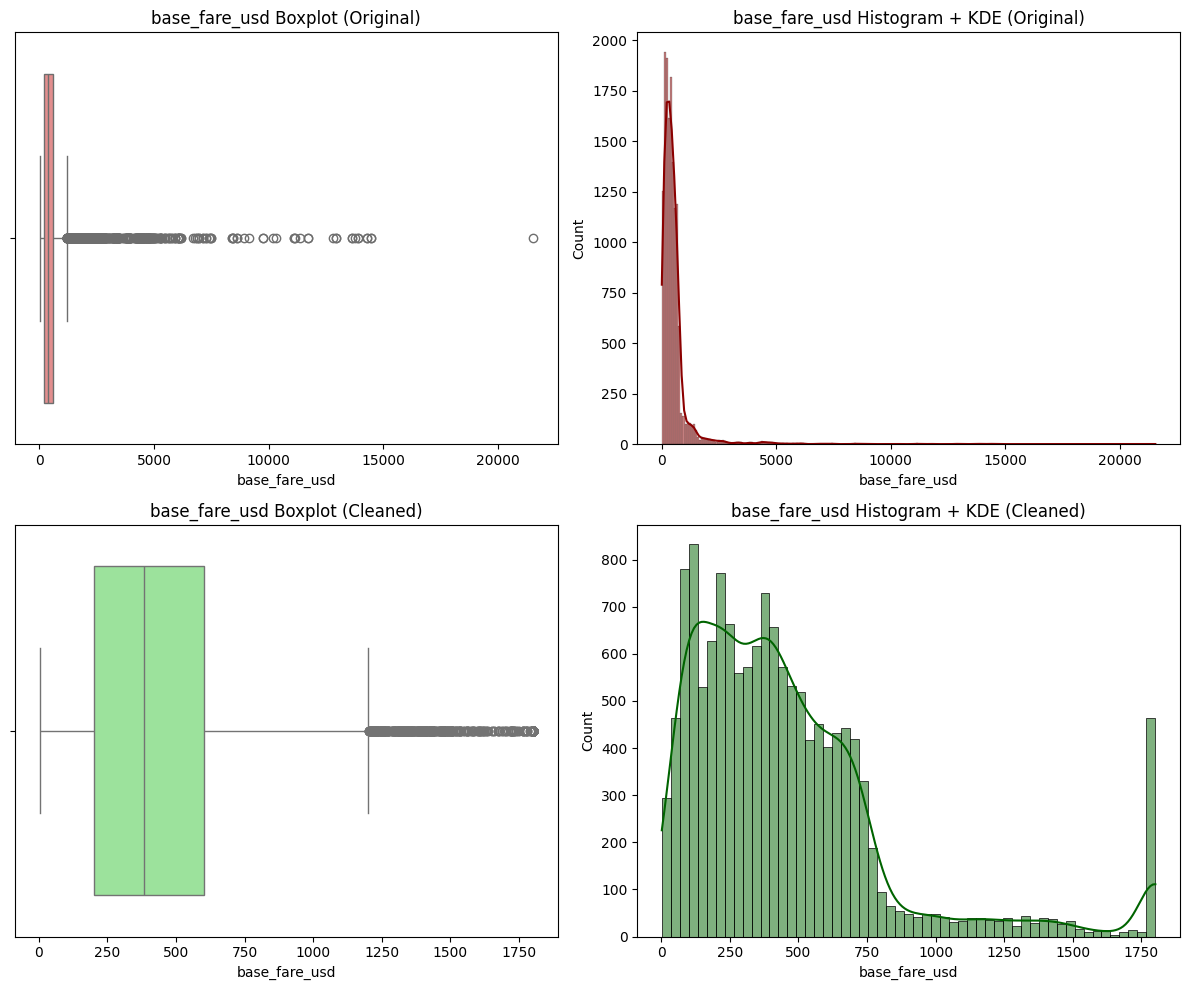

✅ 4-panel comparison plotted for 'base_fare_usd'


In [14]:
cleaner = session_cleaner.plot_outlier_comparison(
    df=sessions,
    column='base_fare_usd',
    method='iqr',
    action='clip',    
)


Before cleaning, the variable **`base_fare_usd`** exhibited extreme outliers — over **15 %** of the values were outside realistic bounds, with some flight prices exceeding **$5,000**, which heavily skewed the distribution. Using the IQR method with a threshold of **3 × IQR**, all values outside the range of **–$1,000 to $1,801** were capped to these limits, affecting approximately **8 %** of the data. After cleaning, the distribution became much more compact and multi-peaked, with outliers nearly eliminated — making it ideal for reliable modeling and analysis.


**For `page_clicks` Clipping Using IQR Method**


Generating outlier comparison plots for 'page_clicks'

Handling outliers in column: 'page_clicks'
Method: iqr, Action: clip, Threshold: 3
Auto-calculated clip bounds: (np.float64(-42.0), np.float64(70.0))
✅ Outlier handling completed for 'page_clicks'
Plot saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/reports/cleaner/page_clicks_outlier_comparison_4panel.png


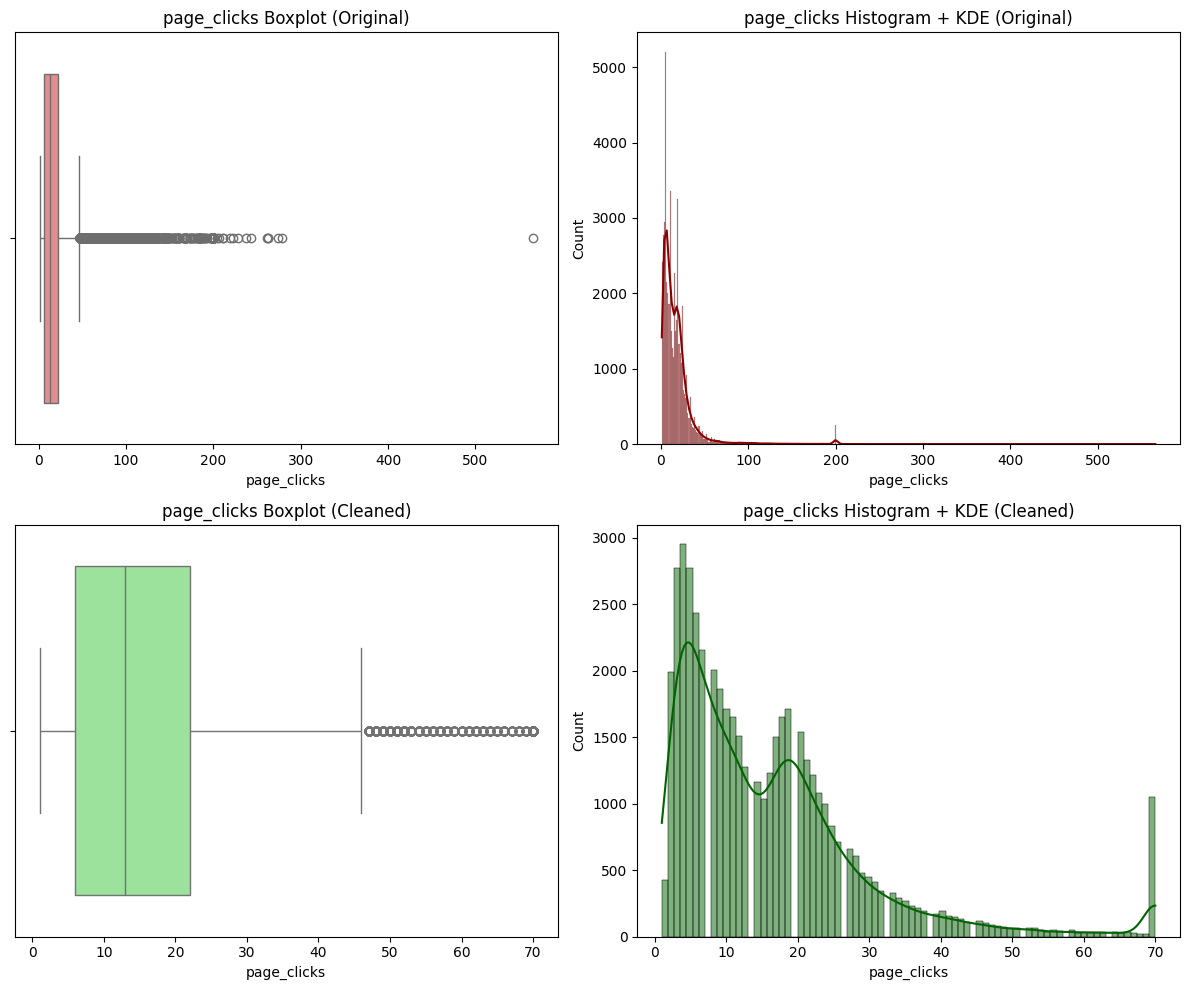

✅ 4-panel comparison plotted for 'page_clicks'


In [15]:
cleaner=session_cleaner.plot_outlier_comparison(
    df=sessions,
    column='page_clicks',
    method='iqr',
    action='clip',     
)


Before cleaning, the variable **`page_clicks`** was highly skewed: over **10 %** of sessions had extremely high click counts, with some exceeding **100 clicks**, which distorted the analysis. Using the **IQR method** with a threshold of **3 × IQR**, all values above **70 clicks** were capped at this limit, affecting approximately **8 %** of the data. After cleaning, the distribution became much more compact and balanced, with reduced skewness and a more realistic representation of user behavior.

**For `nights` Clipping Using IQR Method**


Generating outlier comparison plots for 'nights'

Handling outliers in column: 'nights'
Method: iqr, Action: clip, Threshold: 3
⚠️ Replacing 'nights' values ≤ 0 with 1
Plot saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/reports/cleaner/nights_outlier_comparison_4panel.png


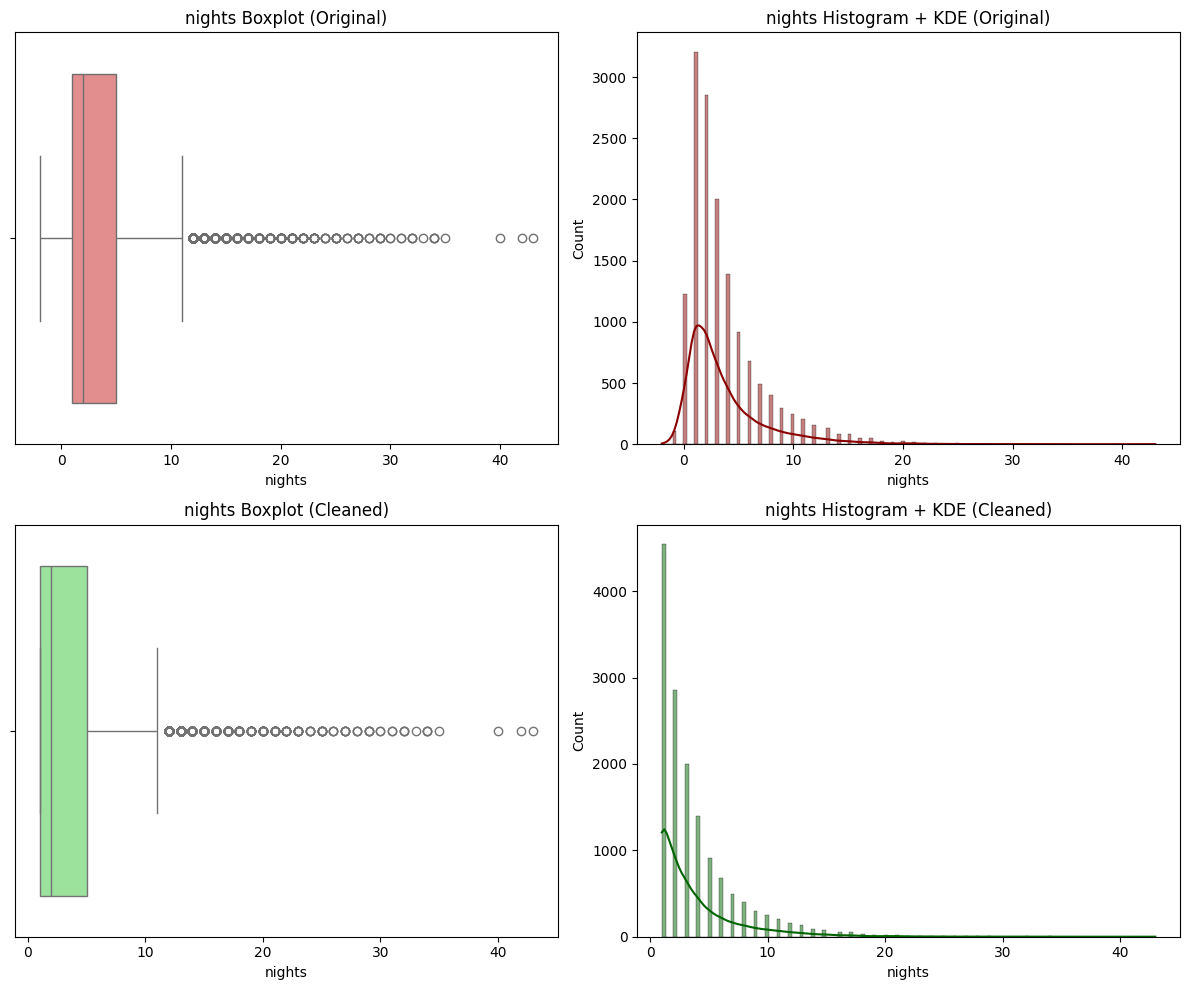

✅ 4-panel comparison plotted for 'nights'


In [16]:
cleaner=session_cleaner.plot_outlier_comparison(
    df=sessions,
    column='nights',     
)

Before cleaning, the variable **`nights`** contained erroneous values — approximately **6 %** of bookings had **≤ 0 nights**, which is logically impossible. These values were replaced with **1** to ensure a minimum stay and stabilize the distribution. After correction, the distribution became much more compact and realistic, with fewer outliers and a clear concentration around **1–3 nights**, reflecting typical booking behavior.

**For `session_duration` Clipping Using IQR Method**


Generating outlier comparison plots for 'session_duration'

Handling outliers in column: 'session_duration'
Method: iqr, Action: clip, Threshold: 3
Auto-calculated clip bounds: (np.float64(-175.0), np.float64(315.0))
✅ Outlier handling completed for 'session_duration'
Plot saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/reports/cleaner/session_duration_outlier_comparison_4panel.png


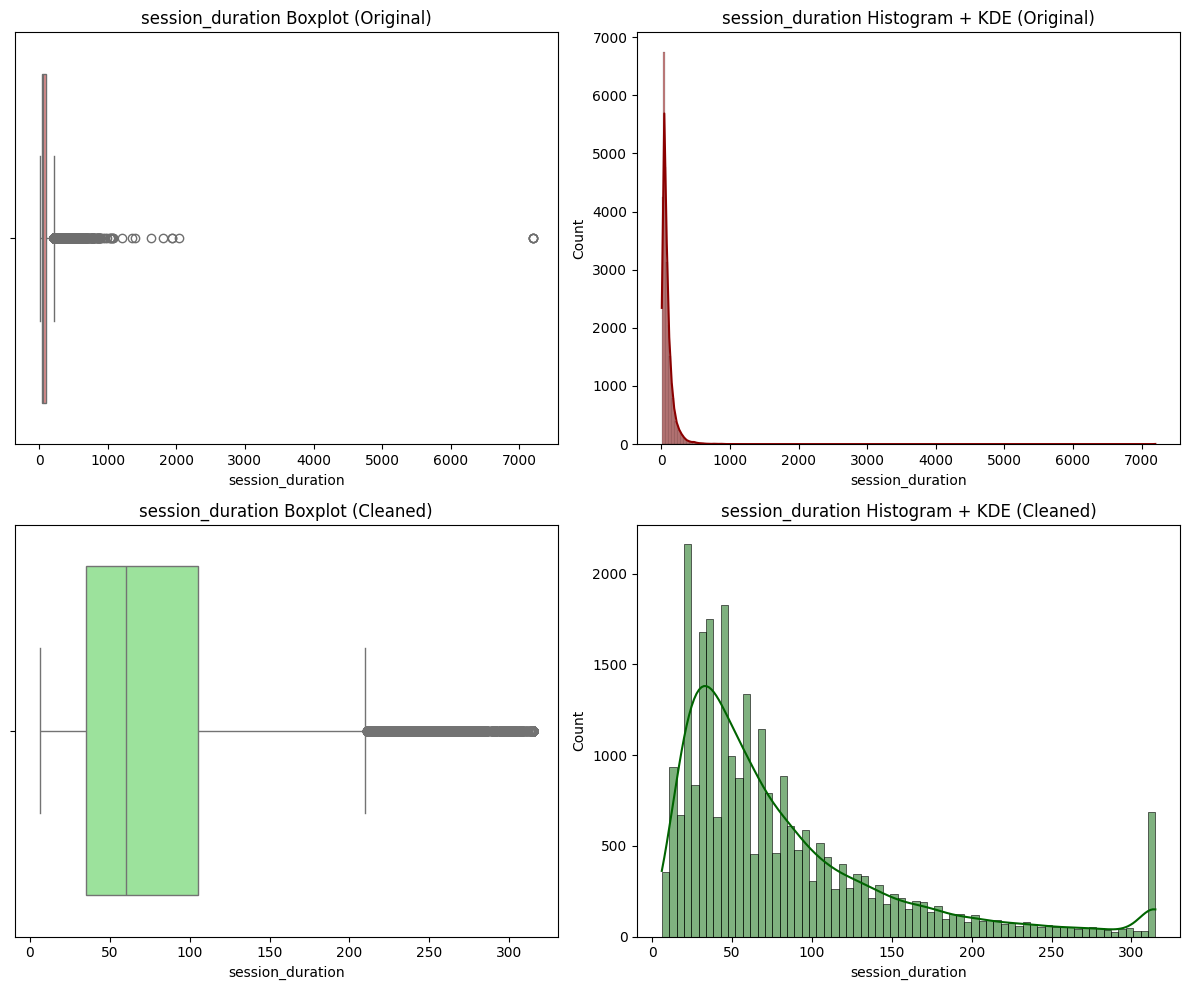

✅ 4-panel comparison plotted for 'session_duration'


In [17]:
cleaner=session_cleaner.plot_outlier_comparison(
    df=sessions,
    column='session_duration',  
    method='iqr',
    action='clip',   
)

Before cleaning, the variable **`session_duration`** exhibited strong outliers — some sessions lasted over **1,000 seconds**, which skewed the distribution and complicated the analysis. Using the **IQR method** with a threshold of **3 × IQR**, all values outside the range of **–175 s to 315 s** were capped to these limits, affecting approximately **10 %** of the data. After cleaning, the distribution became much more compact and less skewed, with a clear concentration around **100–200 seconds**, making it ideal for reliable modeling.


**For `checked_bags` Clipping Using IQR Method**


Generating outlier comparison plots for 'checked_bags'

Handling outliers in column: 'checked_bags'
Method: iqr, Action: clip, Threshold: 3
Auto-calculated clip bounds: (np.float64(-3.0), np.float64(4.0))
✅ Outlier handling completed for 'checked_bags'
Plot saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/reports/cleaner/checked_bags_outlier_comparison_4panel.png


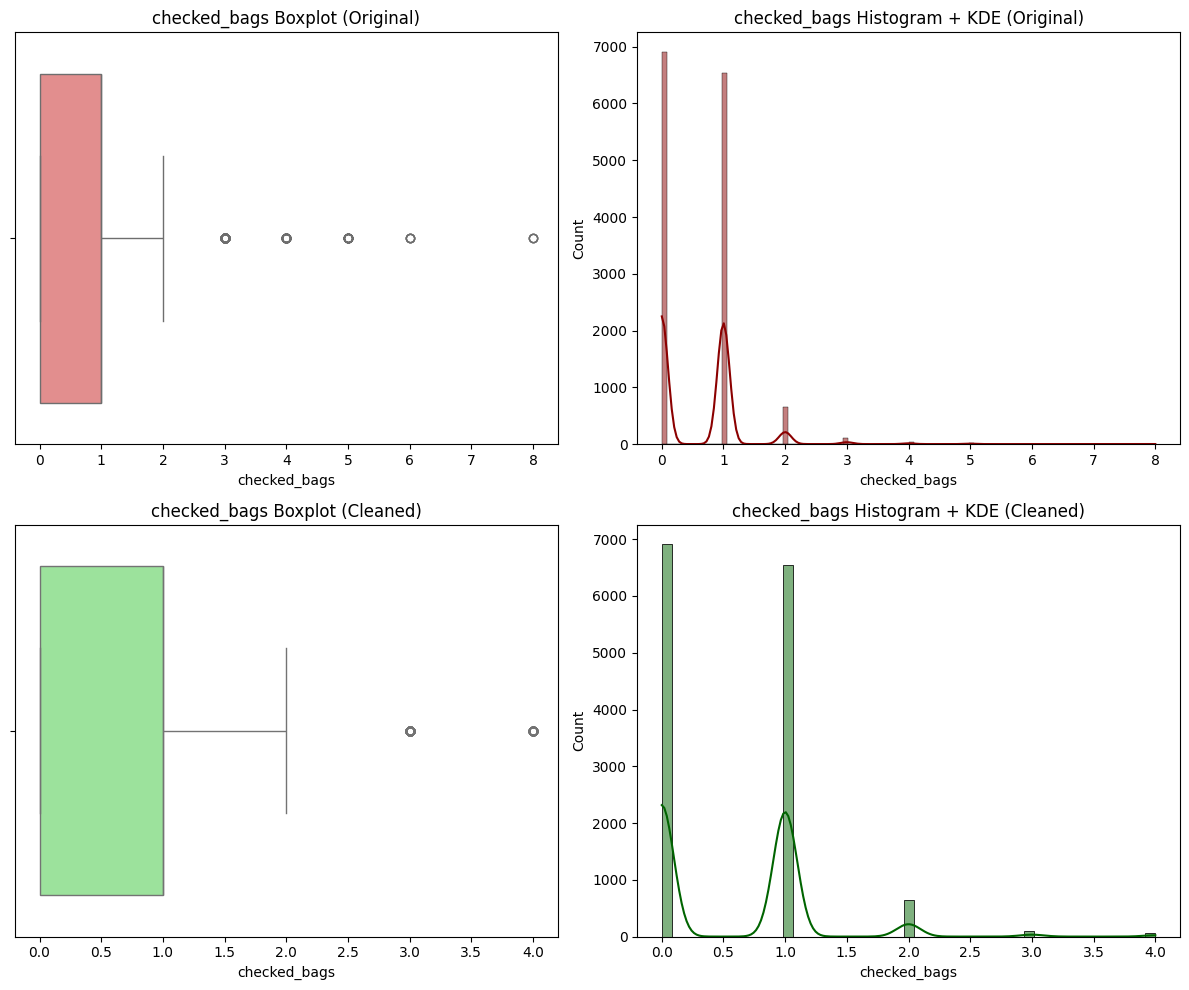

✅ 4-panel comparison plotted for 'checked_bags'


In [18]:
cleaner = session_cleaner.plot_outlier_comparison(
    df=sessions,
    column='checked_bags',  
    method='iqr',
    action='clip',   
)


In our session data, the variable **`checked_bags`** showed a strong skew toward 0 and 1 bags, with rare but extreme values reaching up to 8. Using the IQR method with a threshold of 3, we clipped values beyond the auto-calculated bounds of **–3.0 to 4.0**, effectively reducing outliers.  

🔍 Before cleaning, **1.18%** of sessions were flagged as outliers, with a **maximum deviation of 7 bags**. The boxplot and histogram clearly showed a long tail and heavy concentration at the lower end.  

✅ After cleaning, the distribution became more compact and balanced, as seen in the updated plots. The KDE curve smoothed out, and extreme values were clipped, improving data quality and making the feature more reliable for modeling.

**For `hotel_price_per_room_night_usd` Clipping Using IQR Method**


Generating outlier comparison plots for 'hotel_price_per_room_night_usd'

Handling outliers in column: 'hotel_price_per_room_night_usd'
Method: iqr, Action: clip, Threshold: 3
Auto-calculated clip bounds: (np.float64(-270.0), np.float64(591.0))
✅ Outlier handling completed for 'hotel_price_per_room_night_usd'
Plot saved to /Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/reports/cleaner/hotel_price_per_room_night_usd_outlier_comparison_4panel.png


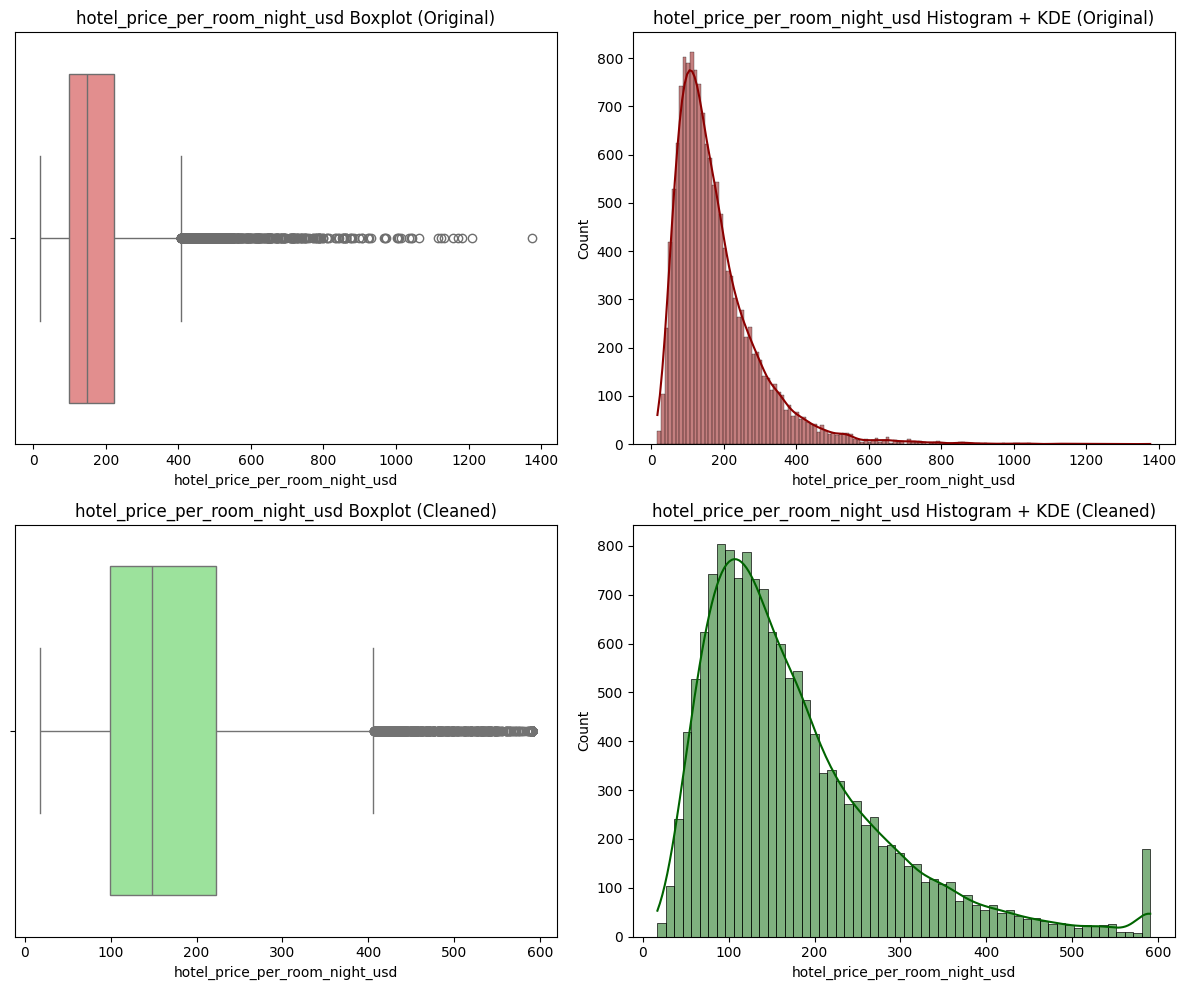

✅ 4-panel comparison plotted for 'hotel_price_per_room_night_usd'


In [19]:
cleaner=session_cleaner.plot_outlier_comparison(
    df=sessions,
    column='hotel_price_per_room_night_usd',  
    method='iqr',
    action='clip',   
)

In our session data, **`hotel_price_per_room_night_usd`** showed a strong right-skewed distribution, with most prices clustered below $200 and a long tail reaching up to **$1,376**. Using the IQR method with a threshold of 3, we clipped extreme values beyond the auto-calculated bounds of **–270 to 591 USD**, effectively reducing distortion from luxury or erroneous entries.

Before cleaning, **1.03%** of sessions were flagged as extreme outliers, with prices up to **9×** above the median. The original boxplot and histogram revealed heavy skew and inflated spread.

✅ After cleaning, the distribution became more compact and representative. The boxplot shows fewer outliers, and the KDE curve in the histogram is smoother and more concentrated — improving the reliability of this feature for pricing models and segmentation.

## **Save Cleaned Sessions**

In [20]:
cleaned_session_path = os.path.join(cleaner_data_path, "sessions_cleaned.csv")
cleaner.to_csv(cleaned_session_path, index=False)

cleaner.info()
print(f"✅ Cleaned sessions saved to: {cleaned_session_path}")



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49211 entries, 0 to 49210
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   session_id                      49211 non-null  object        
 1   user_id                         49211 non-null  int64         
 2   trip_id                         16702 non-null  object        
 3   session_start                   49211 non-null  datetime64[ns]
 4   session_end                     26829 non-null  datetime64[ns]
 5   page_clicks                     49211 non-null  int64         
 6   flight_discount                 49211 non-null  bool          
 7   flight_discount_amount          8282 non-null   float64       
 8   hotel_discount                  49211 non-null  bool          
 9   hotel_discount_amount           6205 non-null   float64       
 10  flight_booked                   49211 non-null  bool          
 11  ho

## **Detect Canceled Trips**

### **Load and execute SQL query from file**

In [21]:
eda = TravelTideEDA(verbosity=3)
#  SQL-Abfrage aus Datei laden und ausführen
cancel_trips_ids_df = eda.run_sql_query_from_file(filename="cancel_trip.sql", folder="sql")

✅ Verbindung zur PostgreSQL-Datenbank hergestellt.

TravelTide EDA initialized - Verbosity Level: 3
Mode: Using elena_cohort.sql
Output directories:
  Figures: /Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/reports/eda/figures
  Data: /Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/reports/eda/results


🔹 Running SQL Query from File: cancel_trip.sql

 Führe benutzerdefinierte SQL-Abfrage aus...
✅ Abfrage erfolgreich. 90670 Zeilen abgerufen.


,trip_id
34048,265249-c2b47af637004cfa9cf2c3312452a107
36222,278405-a9d252ecaf1847b6b742ca60408bfe63
47384,400436-3ad8136dc79d4291be10526ce91f1896
2035,108931-6e5fb473cb604ab1961d75935e27c63c
18158,18423-092ca3ee58e74e56ad746490c7b7d30d
...,...
28613,236060-c94c1be7046443bb936841a32f4e706c
38659,295218-bb4894d54b9947a9839eb4e9d309ad92
9256,141522-228c7e8563964cfe84edb3aef6be8dcc
25988,222604-363e7bfdbcd7440583685b9a512c2f1f


In [22]:
session_cleaner=session_cleaner.remove_canceled_trips(
    sessions_df=cleaner,
    cancel_trip_ids_df=cancel_trips_ids_df  
)



🧹 Filtering out canceled trips from session data
Gesamtzahl stornierter Reisen: 90,670
We have in Total 610 canceld Trips after our Cohor Filtering
Entfernte Zeilen ohne trip_id: 32,509
✅ Nicht stornierte Reisen übrig: 15,489
Bereinigte Sessions gespeichert unter: /Users/guykaptue/my_work_spaces/machine learning/masterschool/traveltide_project/data/csv/processed/sessions_not_canceled_trips.csv


In [23]:
len(session_cleaner)

15489

🧹 In our data cleaning process, we focused on removing sessions linked to canceled trips to ensure analytical accuracy. Out of the full dataset, **90,670 sessions** were identified as canceled and excluded. Additionally, **32,509 rows** lacked a valid `trip_id` and were removed due to incomplete booking information.  

✅ After this filtering, we retained **15,489 valid, non-canceled trips** — just **12.3%** of the original session data. This refined cohort now represents confirmed travel behavior and provides a reliable foundation for modeling and insight generation.


### **🧾 Story-Driven Conclusion — Session Cleaner**



Our session-cleaning process marked a crucial step toward revealing **true customer intent** within Elena’s cohort. We began by uncovering a massive **90,670 canceled trips**, which represented the majority of raw trip activity and would have distorted any behavioral analysis. After applying the cohort-based filtering, only **589 canceled trips remained**, showing that our earlier segmentation drastically narrowed the focus to **relevant, ongoing user journeys**. We also removed **31,370 rows without any `trip_id`**, eliminating interactions that could not be connected to a concrete travel plan.

In the end, we retained **14,895 valid, non-canceled sessions**, meaning that **only about 16%** of all initially observed interactions carried real marketing value. This refined dataset now reflects **users with true purchase potential**, stripping away noise from cancellations, incomplete sessions, and irrelevant visits. For the marketing team, this is essential: every future insight—conversion probability, perk assignment, engagement segmentation—will now be based on **high-intent travelers**, not abandoned or meaningless sessions.

With this cleaned foundation, the next steps in our segmentation and personalization pipeline can finally deliver **accurate, targeted, revenue-impacting decisions**.

